<a href="https://colab.research.google.com/github/junxnone/examples/blob/master/opencv/hand_keypoint_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

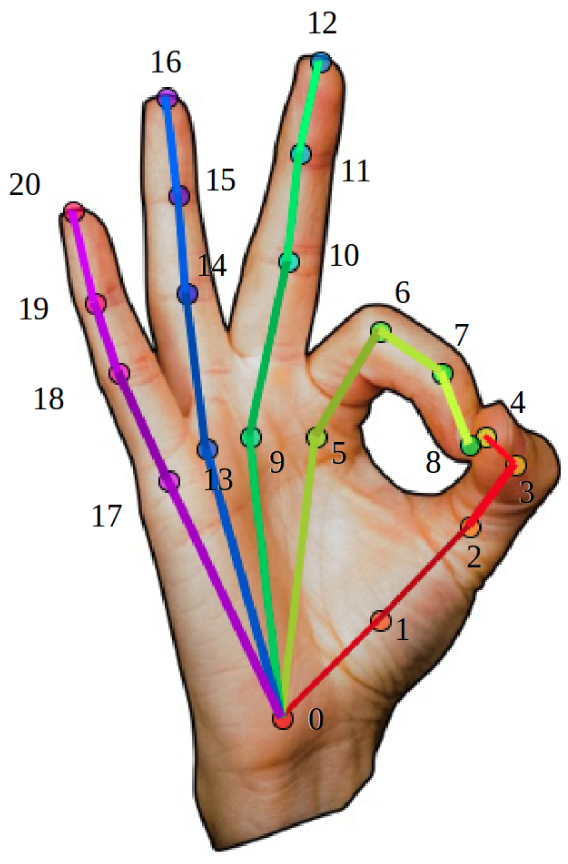
# Reference
- [基于OpenCV DNN 的手部关键点检测](https://www.aiuai.cn/aifarm1111)
- [OpenPose 关键点输出格式](https://www.aiuai.cn/aifarm712.html)

In [1]:
!wget https://raw.githubusercontent.com/CMU-Perceptual-Computing-Lab/openpose/master/models/hand/pose_deploy.prototxt
!wget http://posefs1.perception.cs.cmu.edu/OpenPose/models/hand/pose_iter_102000.caffemodel
!wget https://raw.githubusercontent.com/spmallick/learnopencv/master/HandPose/hand.jpg 
!wget https://raw.githubusercontent.com/spmallick/learnopencv/master/HandPose/right-frontal.jpg
!wget https://raw.githubusercontent.com/spmallick/learnopencv/master/HandPose/front-back.jpg

--2019-12-06 13:26:55--  https://raw.githubusercontent.com/CMU-Perceptual-Computing-Lab/openpose/master/models/hand/pose_deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26452 (26K) [text/plain]
Saving to: ‘pose_deploy.prototxt’

pose_deploy.prototx 100%[===================>]  25.83K  --.-KB/s    in 0.01s   

2019-12-06 13:26:55 (2.05 MB/s) - ‘pose_deploy.prototxt’ saved [26452/26452]

--2019-12-06 13:26:57--  http://posefs1.perception.cs.cmu.edu/OpenPose/models/hand/pose_iter_102000.caffemodel
Resolving posefs1.perception.cs.cmu.edu (posefs1.perception.cs.cmu.edu)... 128.2.176.37
Connecting to posefs1.perception.cs.cmu.edu (posefs1.perception.cs.cmu.edu)|128.2.176.37|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14734402

In [0]:
from __future__ import division
import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

In [0]:
class general_pose_model(object):
    def __init__(self, modelpath):
        self.num_points = 22
        self.point_pairs = [[0,1],[1,2],[2,3],[3,4],
                            [0,5],[5,6],[6,7],[7,8],
                            [0,9],[9,10],[10,11],[11,12],
                            [0,13],[13,14],[14,15],[15,16],
                            [0,17],[17,18],[18,19],[19,20]]
        # self.inWidth = 368
        self.inHeight = 368
        self.threshold = 0.1
        self.hand_net = self.get_hand_model(modelpath)


    def get_hand_model(self, modelpath):

        prototxt   = os.path.join(modelpath, "pose_deploy.prototxt")
        caffemodel = os.path.join(modelpath, "pose_iter_102000.caffemodel")
        hand_model = cv2.dnn.readNetFromCaffe(prototxt, caffemodel)

        return hand_model


    def predict(self, imgfile):
        img_cv2 = cv2.imread(imgfile)
        img_height, img_width, _ = img_cv2.shape
        aspect_ratio = img_width / img_height

        inWidth = int(((aspect_ratio * self.inHeight) * 8) // 8)
        inpBlob = cv2.dnn.blobFromImage(img_cv2, 1.0 / 255, (inWidth, self.inHeight), (0, 0, 0), swapRB=False, crop=False)

        self.hand_net.setInput(inpBlob)

        output = self.hand_net.forward()

        # vis heatmaps
        # self.vis_heatmaps(imgfile, output)
        self.vis_heatmaps_in_one(imgfile, output)
        #
        points = []
        for idx in range(self.num_points):
            probMap = output[0, idx, :, :] # confidence map.
            probMap = cv2.resize(probMap, (img_width, img_height))

            # Find global maxima of the probMap.
            minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

            if prob > self.threshold:
                points.append((int(point[0]), int(point[1])))
            else:
                points.append(None)

        return points


    def vis_heatmaps(self, imgfile, net_outputs):
        img_cv2 = cv2.imread(imgfile)
        plt.figure(figsize=[10, 10])

        for pdx in range(self.num_points):
            probMap = net_outputs[0, pdx, :, :]
            probMap = cv2.resize(probMap, (img_cv2.shape[1], img_cv2.shape[0]))
            plt.subplot(5, 5, pdx+1)
            plt.imshow(cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB))
            plt.imshow(probMap, alpha=0.6)
            plt.colorbar()
            plt.axis("off")
        plt.show()

    def vis_heatmaps_in_one(self, imgfile, net_outputs):
        img_cv2 = cv2.imread(imgfile)
        plt.figure(figsize=[10, 10])


        mix = np.zeros((img_cv2.shape[0], img_cv2.shape[1]))
        for pdx in range(self.num_points):
            probMap = net_outputs[0, pdx, :, :]
            probMap = cv2.resize(probMap, (img_cv2.shape[1], img_cv2.shape[0]))
            mix = mix + probMap
        
        plt.imshow(cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB))
        plt.imshow(probMap, alpha=0.6)
        plt.colorbar()
        plt.axis("off")
        plt.show()

    def vis_pose(self, imgfile, points):
        img_cv2 = cv2.imread(imgfile)
        img_cv2_copy = np.copy(img_cv2)
        for idx in range(len(points)):
            if points[idx]:
                cv2.circle(img_cv2_copy, points[idx], 8, (0, 255, 255), thickness=-1,
                           lineType=cv2.FILLED)
                cv2.putText(img_cv2_copy, "{}".format(idx), points[idx], cv2.FONT_HERSHEY_SIMPLEX,
                            1, (0, 0, 255), 2, lineType=cv2.LINE_AA)

        # Draw Skeleton
        for pair in self.point_pairs:
            partA = pair[0]
            partB = pair[1]

            if points[partA] and points[partB]:
                cv2.line(img_cv2, points[partA], points[partB], (0, 255, 255), 3)
                cv2.circle(img_cv2, points[partA], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

        plt.figure(figsize=[10, 10])
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(img_cv2_copy, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

In [0]:
modelpath = "./"
pose_model = general_pose_model(modelpath)

In [0]:
def predict_and_vis_pose(image_path):
  res_points = pose_model.predict(image_path)
  pose_model.vis_pose(image_path, res_points)

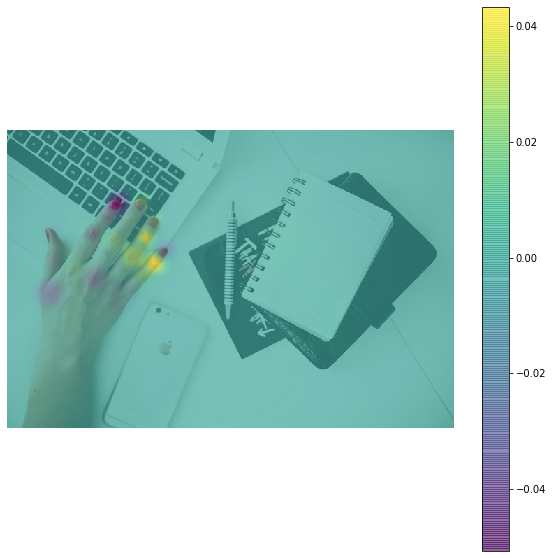

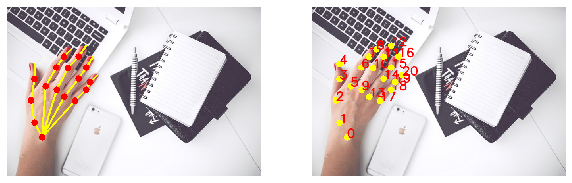

In [140]:
predict_and_vis_pose('./hand.jpg')

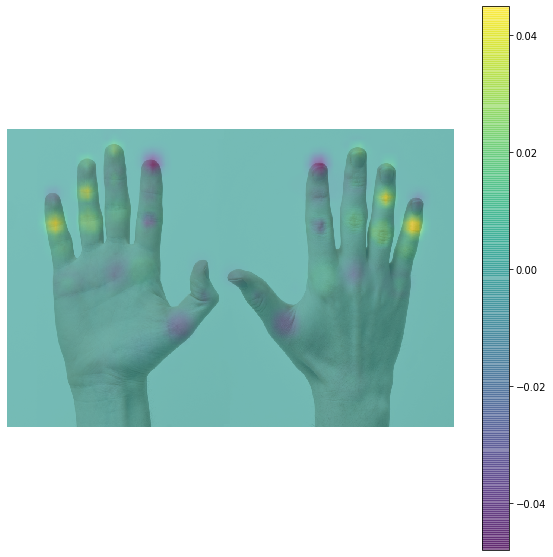

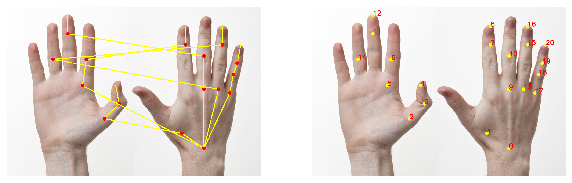

In [141]:
predict_and_vis_pose('./front-back.jpg')

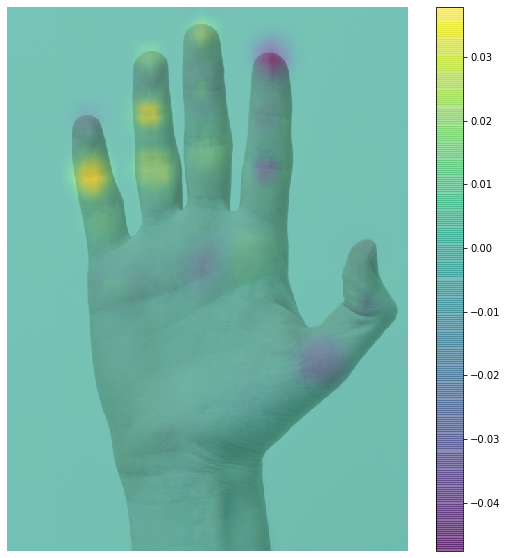

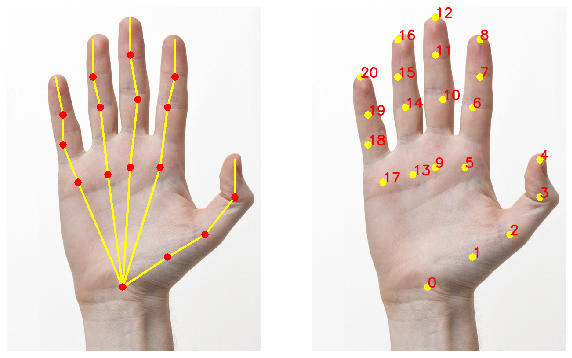

In [142]:
predict_and_vis_pose('./right-frontal.jpg')